In [3]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR100
import os

import numpy as np

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


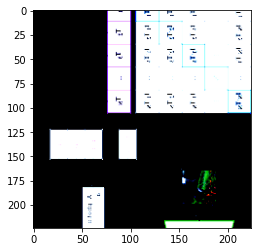

In [27]:
tmp = image[0].T
plt.imshow(tmp)

In [29]:
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)
text.shape

torch.Size([3, 77])

In [31]:
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.99279356 0.00421067 0.00299574]]


In [4]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [37]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Prepare the inputs
image, class_id = cifar100[3637]
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")

100%|██████████| 169001437/169001437 [00:17<00:00, 9524986.94it/s] 


Extracting /home/nikhil/.cache/cifar-100-python.tar.gz to /home/nikhil/.cache

Top predictions:

           snake: 65.31%
          turtle: 12.29%
    sweet_pepper: 3.83%
          lizard: 1.88%
       crocodile: 1.75%


In [4]:
from swin_transformer import SwinTransformer

net = SwinTransformer(
    hidden_dim=96,
    layers=(2, 2, 6, 2),
    heads=(3, 6, 12, 24),
    channels=3,
    num_classes=3,
    head_dim=32,
    window_size=7,
    downscaling_factors=(4, 2, 2, 2),
    relative_pos_embedding=True
)
dummy_x = torch.randn(1, 3, 224, 224)
logits = net(dummy_x)  # (1,3)
print(net)
print(logits)

SwinTransformer(
  (stage1): StageModule(
    (patch_partition): PatchMerging(
      (patch_merge): Unfold(kernel_size=4, dilation=1, padding=0, stride=4)
      (linear): Linear(in_features=48, out_features=96, bias=True)
    )
    (layers): ModuleList(
      (0): ModuleList(
        (0): SwinBlock(
          (attention_block): Residual(
            (fn): PreNorm(
              (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (fn): WindowAttention(
                (to_qkv): Linear(in_features=96, out_features=288, bias=False)
                (to_out): Linear(in_features=96, out_features=96, bias=True)
              )
            )
          )
          (mlp_block): Residual(
            (fn): PreNorm(
              (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (fn): FeedForward(
                (net): Sequential(
                  (0): Linear(in_features=96, out_features=384, bias=True)
                  (1): GELU(approximate='none